<img src="assets/misk-ga.png" align="center"/>

# Table of Contents
1. [Project Proposal](#I---Project-Proposal:-League-of-Legends---Match-Predictor)  
    1.1 [Background](#Background:)  
    1.2 [Objectives](#Objectives:)  
    1.3 [The Data Set](#The-Data-Set:)  
    1.4 [Hypothesis](#Hypothesis:)  
    1.5 [RIsks/Limitations](#Risks/Limitations:)  
2. [Brief EDA](#II---Brief-EDA)  
    2.1 [Loading the data](#Loading-the-data:)  
    2.2 [Combining the data](#Combining-all-the-data-from-the-different-regions:)  
    2.3 [Data Dictionary](#Data-Dictionary:)  
3. [Machine Learning](#III---Machine-Learning)  
    3.1 [Setup](#Setup:)  
    3.2 [Logistic Regression](#Logistic-Regression:)  
    3.3 [Random Forests](#Random-Forests:)  
    3.4 [Gradient Boosting](#Gradient-Boosting:)  
    3.5 [Exploring Random Forests, and Gradient Boosting](#Exploring-Random-Forests,-and-Gradient-Boosting:)  
    3.6 [GridSearchCV](#GridSearchCV:)  
    3.7 [Scalers](#Scalers:)  
4. [Conclusion](#Conclusion:)

# I - Project Proposal: League of Legends - Match Predictor

## Background:

### For my final project I'm attempting to predict the winning team of a League of Legends match while spectating, which could help teams simulate team compositions to try and find the best compistion against a certain opponent.

### This project actually could serve as an intro to a bigger project that I'm planning to work on, which is to create a League of Legends coach that could coach you with every step of the way to help you improve your knowledge and gameplay.

## Objectives:
* ### Analyze what most affects a game's outcome.
* ### Predict the winning team in a consistent matter.

## The Data Set:

### The data has been collected using the offical [Riot Games API](https://developer.riotgames.com/), and has been studied beforehand to ensure that I get only the needed data from a match. (some features have been pre-engineered while collecting the data, for easier usage.)

## Hypothesis:

### My initial hypothesis is that the player's skill far outways the champion's strength when deciding the winning team, but when all players are of equal skill then it depends on the best team's composition and synergy.

### The reason I think player's skill is very important is because when high ranked players play against lowered rank ones it usually doesn't matter what champion they pick, since their game knowledge leads to a win in the end.

## Risks/Limitations:

### Some of the risks come from the data itself, since it could be a little biased because it has been collected through different regions, and player skills. Also, games sometimes end in a sudden manner (e.g., winning team losing their lead because of a minor mistake that could lead to the enemy team snow balling their advantage to a win, or could be because a team member was tilted (getting mad at his teammates for some reason).

# II - Brief EDA

## Loading the data:

In [2]:
%matplotlib inline

from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn settings.
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, auc, classification_report
from sklearn.preprocessing import RobustScaler

regions = ['eune', 'euw', 'na', 'kr', 'jp', 'tr', 'oce', 'br', 'lan', 'ru', 'las']

In [33]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

### Combining all the data from the different regions:

In [3]:
df = pd.DataFrame()
df_region = dict()

for region in regions:
    temp_df = pd.read_csv(f'data_{region}.csv')
    df_region[region] = temp_df
    
    temp_df['region'] = region
    df = df.append(temp_df)

df.shape

(18308, 103)

In [201]:
df.head()

,match_id,1_kda,1_winrate,1_cm_points,1_cm_level,1_runes,1_role,1_champion,1_champion_winrate,1_champion_pickrate,...,10_cm_points,10_cm_level,10_runes,10_role,10_champion,10_champion_winrate,10_champion_pickrate,10_champion_banrate,won,region
0,2247671800,1.31,0.2,1080452,7,Arcane Comet,Role.solo,Lux,50.44,8.86,...,248084,7,Conqueror,Role.none,Lee Sin,47.46,11.51,1.34,1,eune
1,2247903911,3.55,1.0,266017,7,Press the Attack,Role.duo_carry,Draven,49.56,4.20,...,202116,7,Arcane Comet,Role.solo,Camille,47.97,3.40,0.19,1,eune
2,2247874642,3.83,0.5,361640,7,Arcane Comet,Role.solo,Xerath,50.85,3.28,...,111927,5,Conqueror,Role.solo,Aatrox,47.46,4.76,3.09,0,eune
3,2247565707,0.00,0.0,125787,7,Press the Attack,Role.duo_carry,Lucian,48.18,7.49,...,58676,7,Hail of Blades,Role.none,Rek'Sai,50.92,1.75,0.19,0,eune
4,2247891175,2.50,1.0,202116,7,Arcane Comet,Role.duo,Camille,47.97,3.40,...,751937,7,Electrocute,Role.duo,Lux,50.44,8.86,0.49,1,eune


In [6]:
# Save all of the data into one csv file for easier managing later on.

df.to_csv('data.csv', index=None, header=True)

## Data Dictionary:

| Field Name        	| Description                                                                                                            	|
|:-------------------	|:------------------------------------------------------------------------------------------------------------------------	|
| kda               	| Player's kills, deaths, and assists ratio on his chosen champion in the last two patches. (0 if hasn't played before). 	|
| winrate           	| Same as above, but for wins instead of his kda.                                                                        	|
| cm_points         	| Player's champion mastery points, which are collected by playing the champion.                                         	|
| cm_level          	| Player's champion master level, these work like milestones each time the player reaches a certain amount of points.    	|
| runes             	| Player's chosen rune.                                                                                                  	|
| role              	| Player's role in the match, which tells if he has queued up for the match solo, or with a duo partner.                 	|
| champion          	| Player's chosen champion.                                                                                              	|
| champion_winrate  	| Champion's win ratio in the current patch.                                                                             	|
| champion_pickrate 	| Champion's pick ratio in the current patch.                                                                            	|
| champion_banrate  	| Champion's ban ratio in the current patch.                                                                             	|
| region              	| Region of the match.                                                                             	                        |
| won                	| Our target.                                                                                   	                     |

In [19]:
# The data set seems to be split evenly, so there should not be a problem with the majority class dominating.

df.won.mean()

0.5038780860825869

In [26]:
df.describe()

,match_id,1_kda,1_winrate,1_cm_points,1_cm_level,1_champion_winrate,1_champion_pickrate,1_champion_banrate,2_kda,2_winrate,...,9_champion_pickrate,9_champion_banrate,10_kda,10_winrate,10_cm_points,10_cm_level,10_champion_winrate,10_champion_pickrate,10_champion_banrate,won
count,1.830800e+04,18308.000000,18308.000000,1.830800e+04,18308.000000,18308.000000,18308.000000,18308.000000,18308.000000,18308.000000,...,18308.000000,18308.000000,18308.000000,18308.000000,1.830800e+04,18308.000000,18308.000000,18308.00000,18308.000000,18308.000000
mean,1.350829e+09,2.802247,0.418688,1.703281e+05,5.391414,49.926153,5.483483,1.068748,2.875094,0.422605,...,5.520688,1.089373,2.830250,0.422767,1.724042e+05,5.408128,49.898719,5.47400,1.082179,0.503878
std,1.324414e+09,2.772023,0.366135,3.228744e+05,1.674944,2.047373,3.333474,1.262650,2.887834,0.369521,...,3.349223,1.264856,2.779701,0.366983,3.213770e+05,1.669805,2.077195,3.30513,1.254084,0.499999
min,2.050901e+08,0.000000,0.000000,0.000000e+00,0.000000,43.460000,0.500000,0.010000,0.000000,0.000000,...,0.500000,0.010000,0.000000,0.000000,0.000000e+00,0.000000,43.460000,0.50000,0.010000,0.000000
25%,2.518053e+08,0.000000,0.000000,2.088775e+04,4.000000,48.780000,2.820000,0.180000,0.000000,0.000000,...,2.950000,0.180000,0.000000,0.000000,2.163650e+04,5.000000,48.340000,2.95000,0.180000,0.000000
50%,7.385503e+08,2.625000,0.500000,5.866800e+04,6.000000,50.440000,4.540000,0.570000,2.660000,0.500000,...,4.640000,0.580000,2.650000,0.500000,6.089850e+04,6.000000,50.440000,4.54000,0.580000,1.000000
75%,2.249686e+09,4.240000,0.670000,1.690442e+05,7.000000,51.220000,7.490000,1.340000,4.340000,0.690000,...,7.490000,1.362500,4.290000,0.680000,1.719472e+05,7.000000,51.220000,7.49000,1.340000,1.000000
max,4.173398e+09,32.000000,1.000000,5.115920e+06,7.000000,54.400000,14.200000,5.140000,32.000000,1.000000,...,14.200000,5.140000,31.000000,1.000000,5.117117e+06,7.000000,54.400000,14.20000,5.140000,1.000000


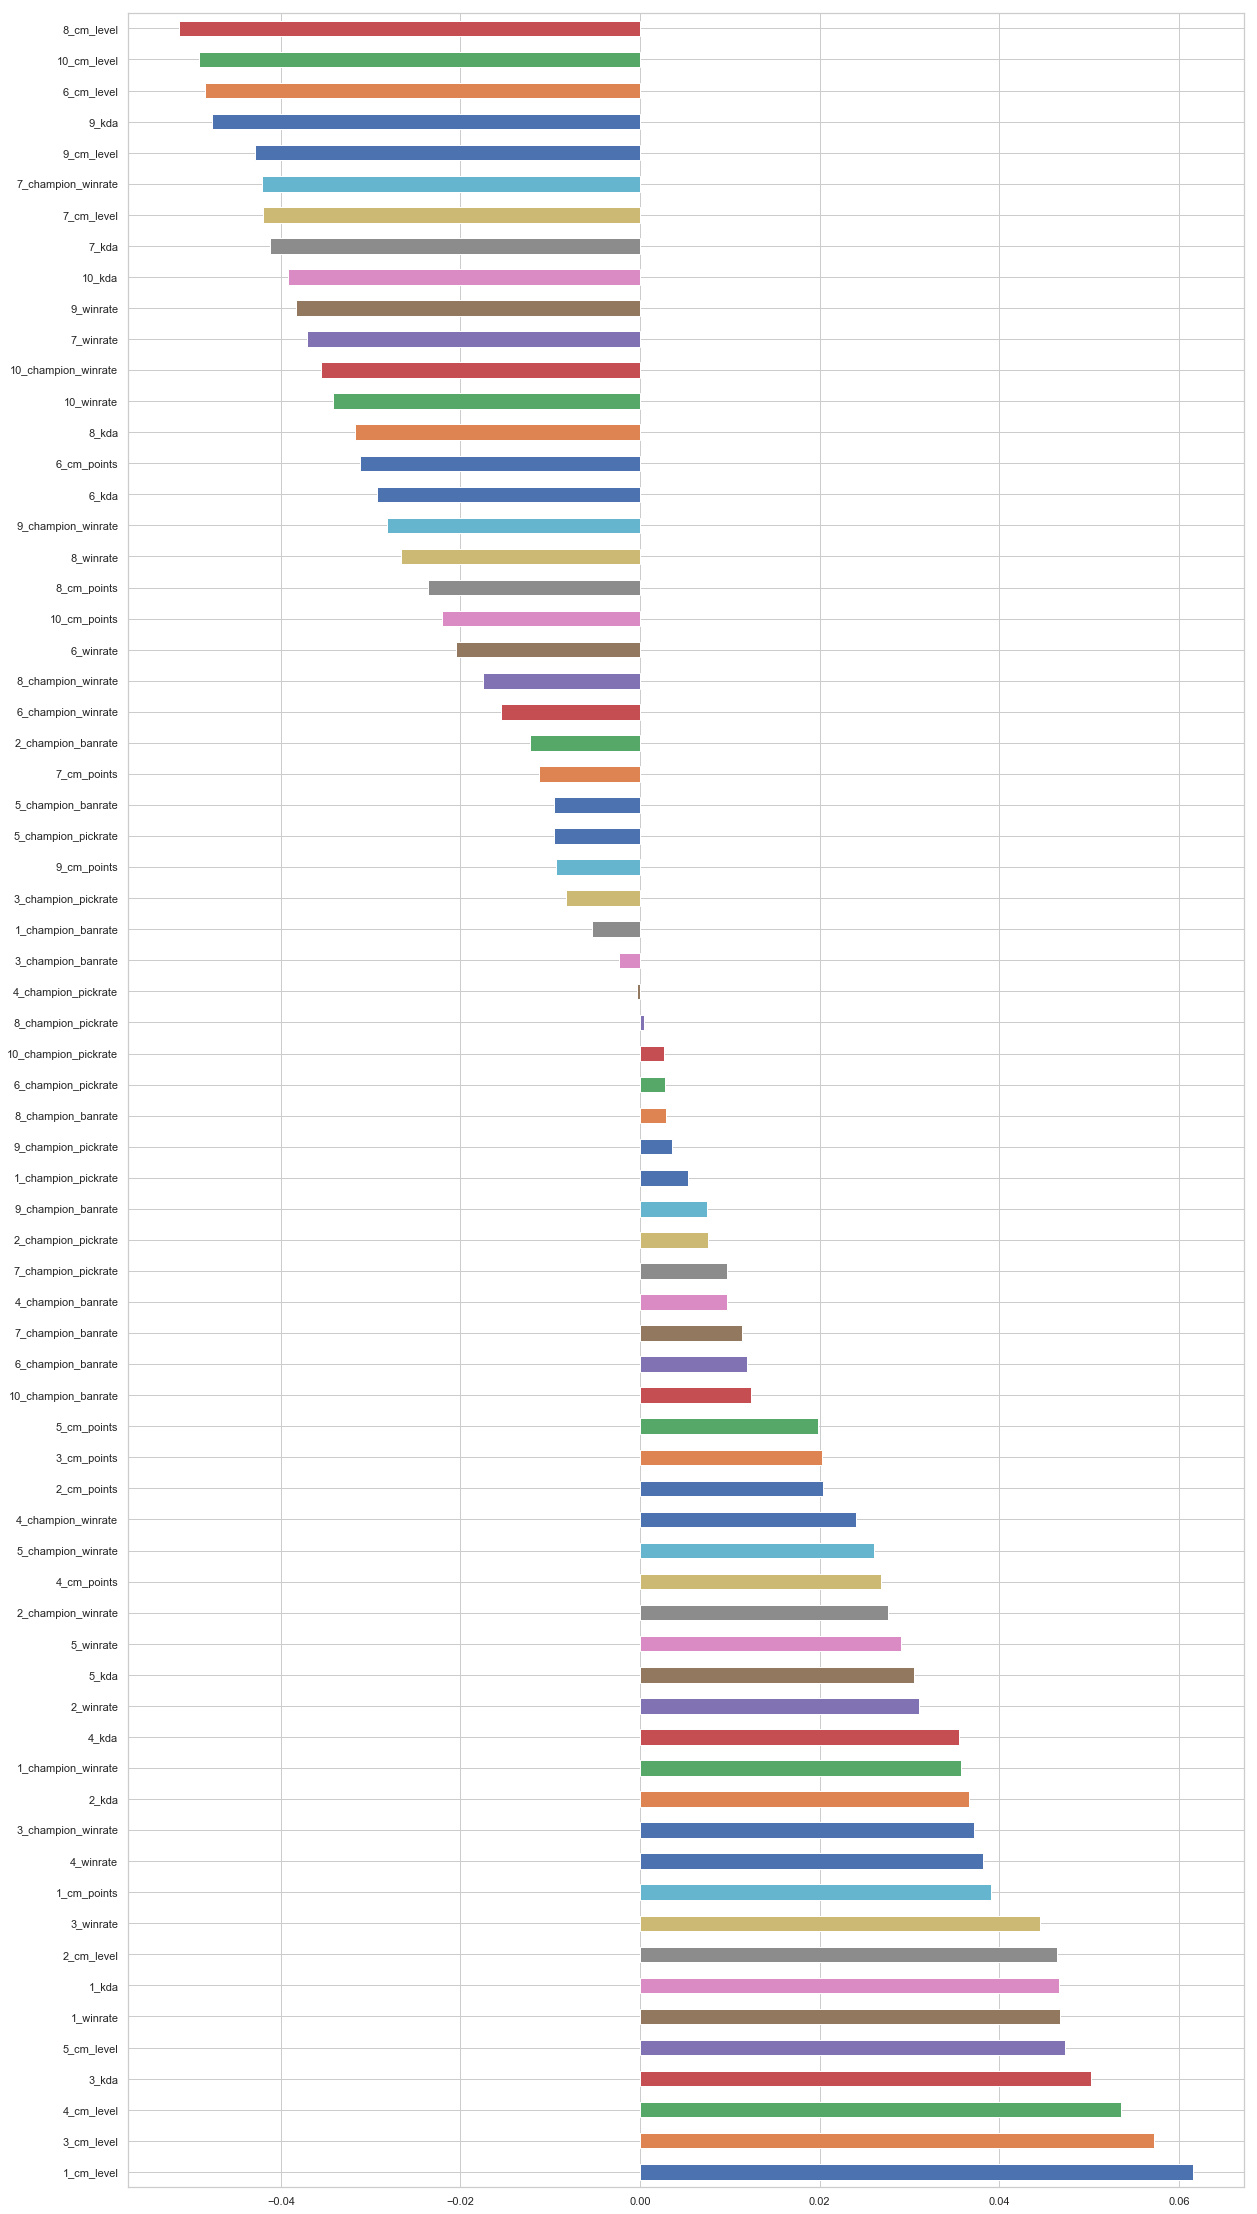

In [202]:
df.corrwith(df['won']).drop(['won', 'match_id']).sort_values(ascending=False).plot(kind='barh', figsize=(20, 40));

### Checking for outliers in the cm_points column:

In [4]:
# I suspect that there are a lot of outliers in these columns, because the way people play this game some players stick
# one champion and become a "One Trick Pony", or become a "Jack of all trades" and play a lot of champions.

points_columns = list()

for i in range(1, 11):
    points_columns.append(f'{i}_cm_points')

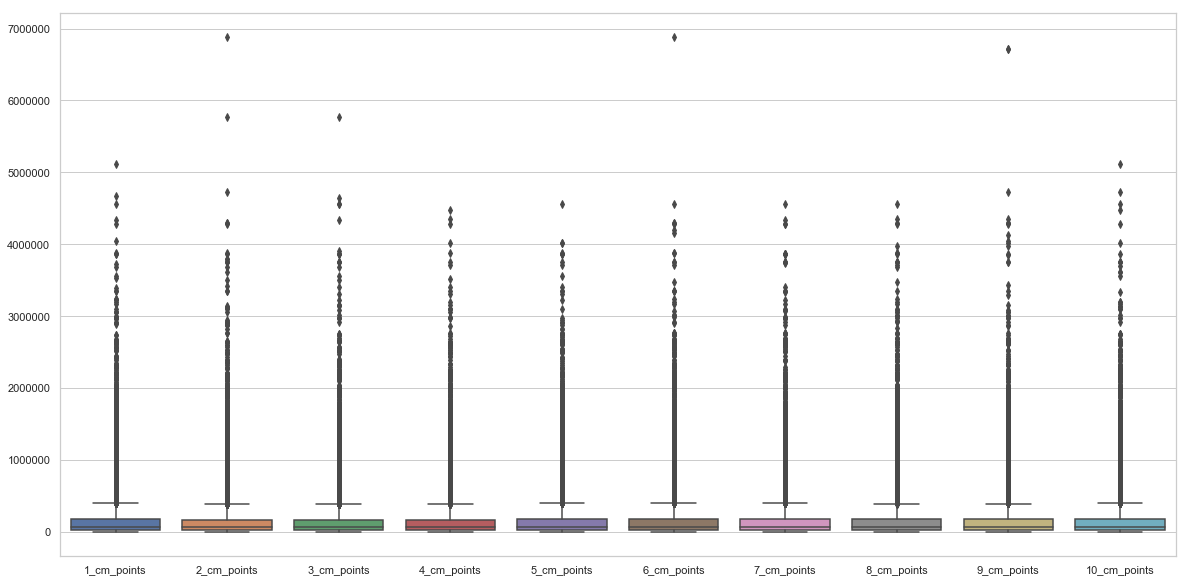

In [143]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df[points_columns]);

In [5]:
def remove_outliers(df, value):
    temp_df = df
    
    for column in points_columns:
        temp_df = temp_df[temp_df[column] < value]
    
    return temp_df

In [6]:
# I chose 500K to be the cut off point after trying multiple values, and finding this to give the best results.

df_no_outliers = remove_outliers(df, 500000)

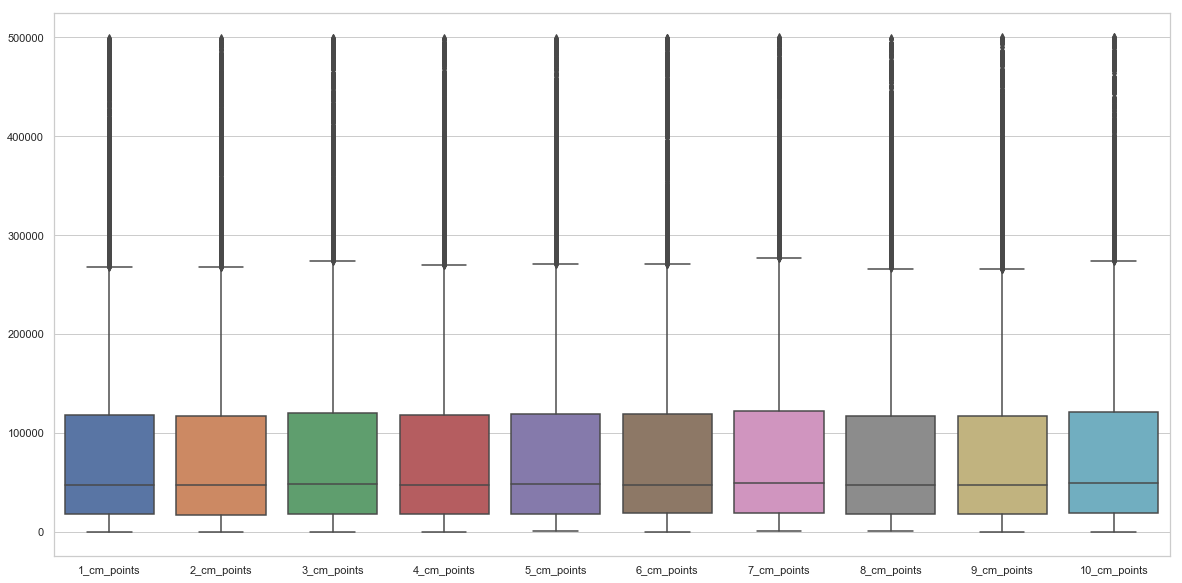

In [257]:
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_no_outliers[points_columns]);

In [258]:
df_no_outliers.shape

(7913, 103)

In [74]:
# The data is still split evenly, so this shouldn't be a problem.

df_no_outliers.won.mean()

0.5043599140654619

### This reduced the outliers count a bit, but with the way champion mastery works there will always be outliers in this field.

### Removing NaN values from kda columns:

In [159]:
kda_columns = list()

for i in range(1, 11):
    kda_columns.append(f'{i}_kda')

In [160]:
df_no_nan = df

for column in kda_columns:
    df_no_nan = df_no_nan[df_no_nan[column] != 0]

In [161]:
df_no_nan.shape

(1007, 103)

### This unfortunately resulted in losing almost all of the data, this could be avoided in the future when collecting new data by including older patches as well (since this column focuses on older matches on the player's chosen champion), or collect more matches over all.

### Exploring the cm_level columns:

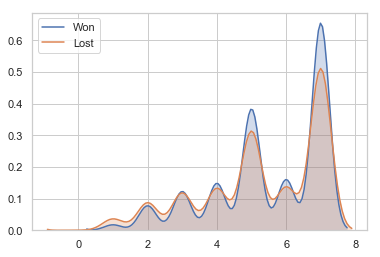

In [165]:
sns.kdeplot(df['1_cm_level'][df['won'] == 1], shade=True)
sns.kdeplot(df['1_cm_level'][df['won'] == 0], shade=True)
plt.legend(['Won', 'Lost'])
plt.show();

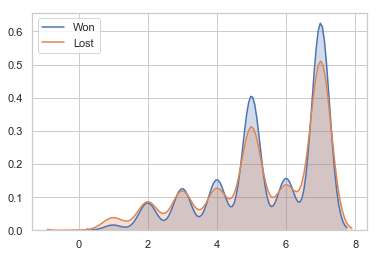

In [166]:
sns.kdeplot(df['2_cm_level'][df['won'] == 1], shade=True)
sns.kdeplot(df['2_cm_level'][df['won'] == 0], shade=True)
plt.legend(['Won', 'Lost'])
plt.show();

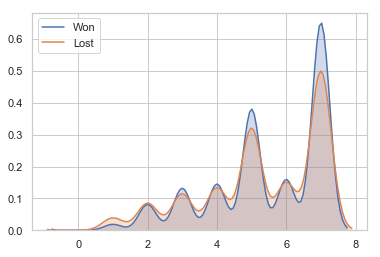

In [167]:
sns.kdeplot(df['3_cm_level'][df['won'] == 1], shade=True)
sns.kdeplot(df['3_cm_level'][df['won'] == 0], shade=True)
plt.legend(['Won', 'Lost'])
plt.show();

### We can quickly notice a trend, that champion's mastery level doesn't affect the match that much result unless it's level 7 (The highest level you can achieve in the game).

### Level 1, and 5 seem to affect this also, but that's probably because level 1 means that the player is still learning how to play the champion, and level 5 could mean that the player stopped leveling up his champion since it starts costing in-game currency to level up to 6, and 7.

### I don't think this column could be that useful for us, since it's not telling us much.

### I won't be using the champion pickrate, and banrate columns. Because I don't think it affects the match's outcome, since it only tells us how much popular or hated a certain champion is.

### Exploring the champion pool, that we collected:

In [449]:
# getting english champion names only, since the data set uses data from different regions the champion column contains
# champion names in different languages.

champions = df['2_champion'].unique()[:145]

df_english_only = df[df['2_champion'].isin(champions)]

champions

(11993, 103)

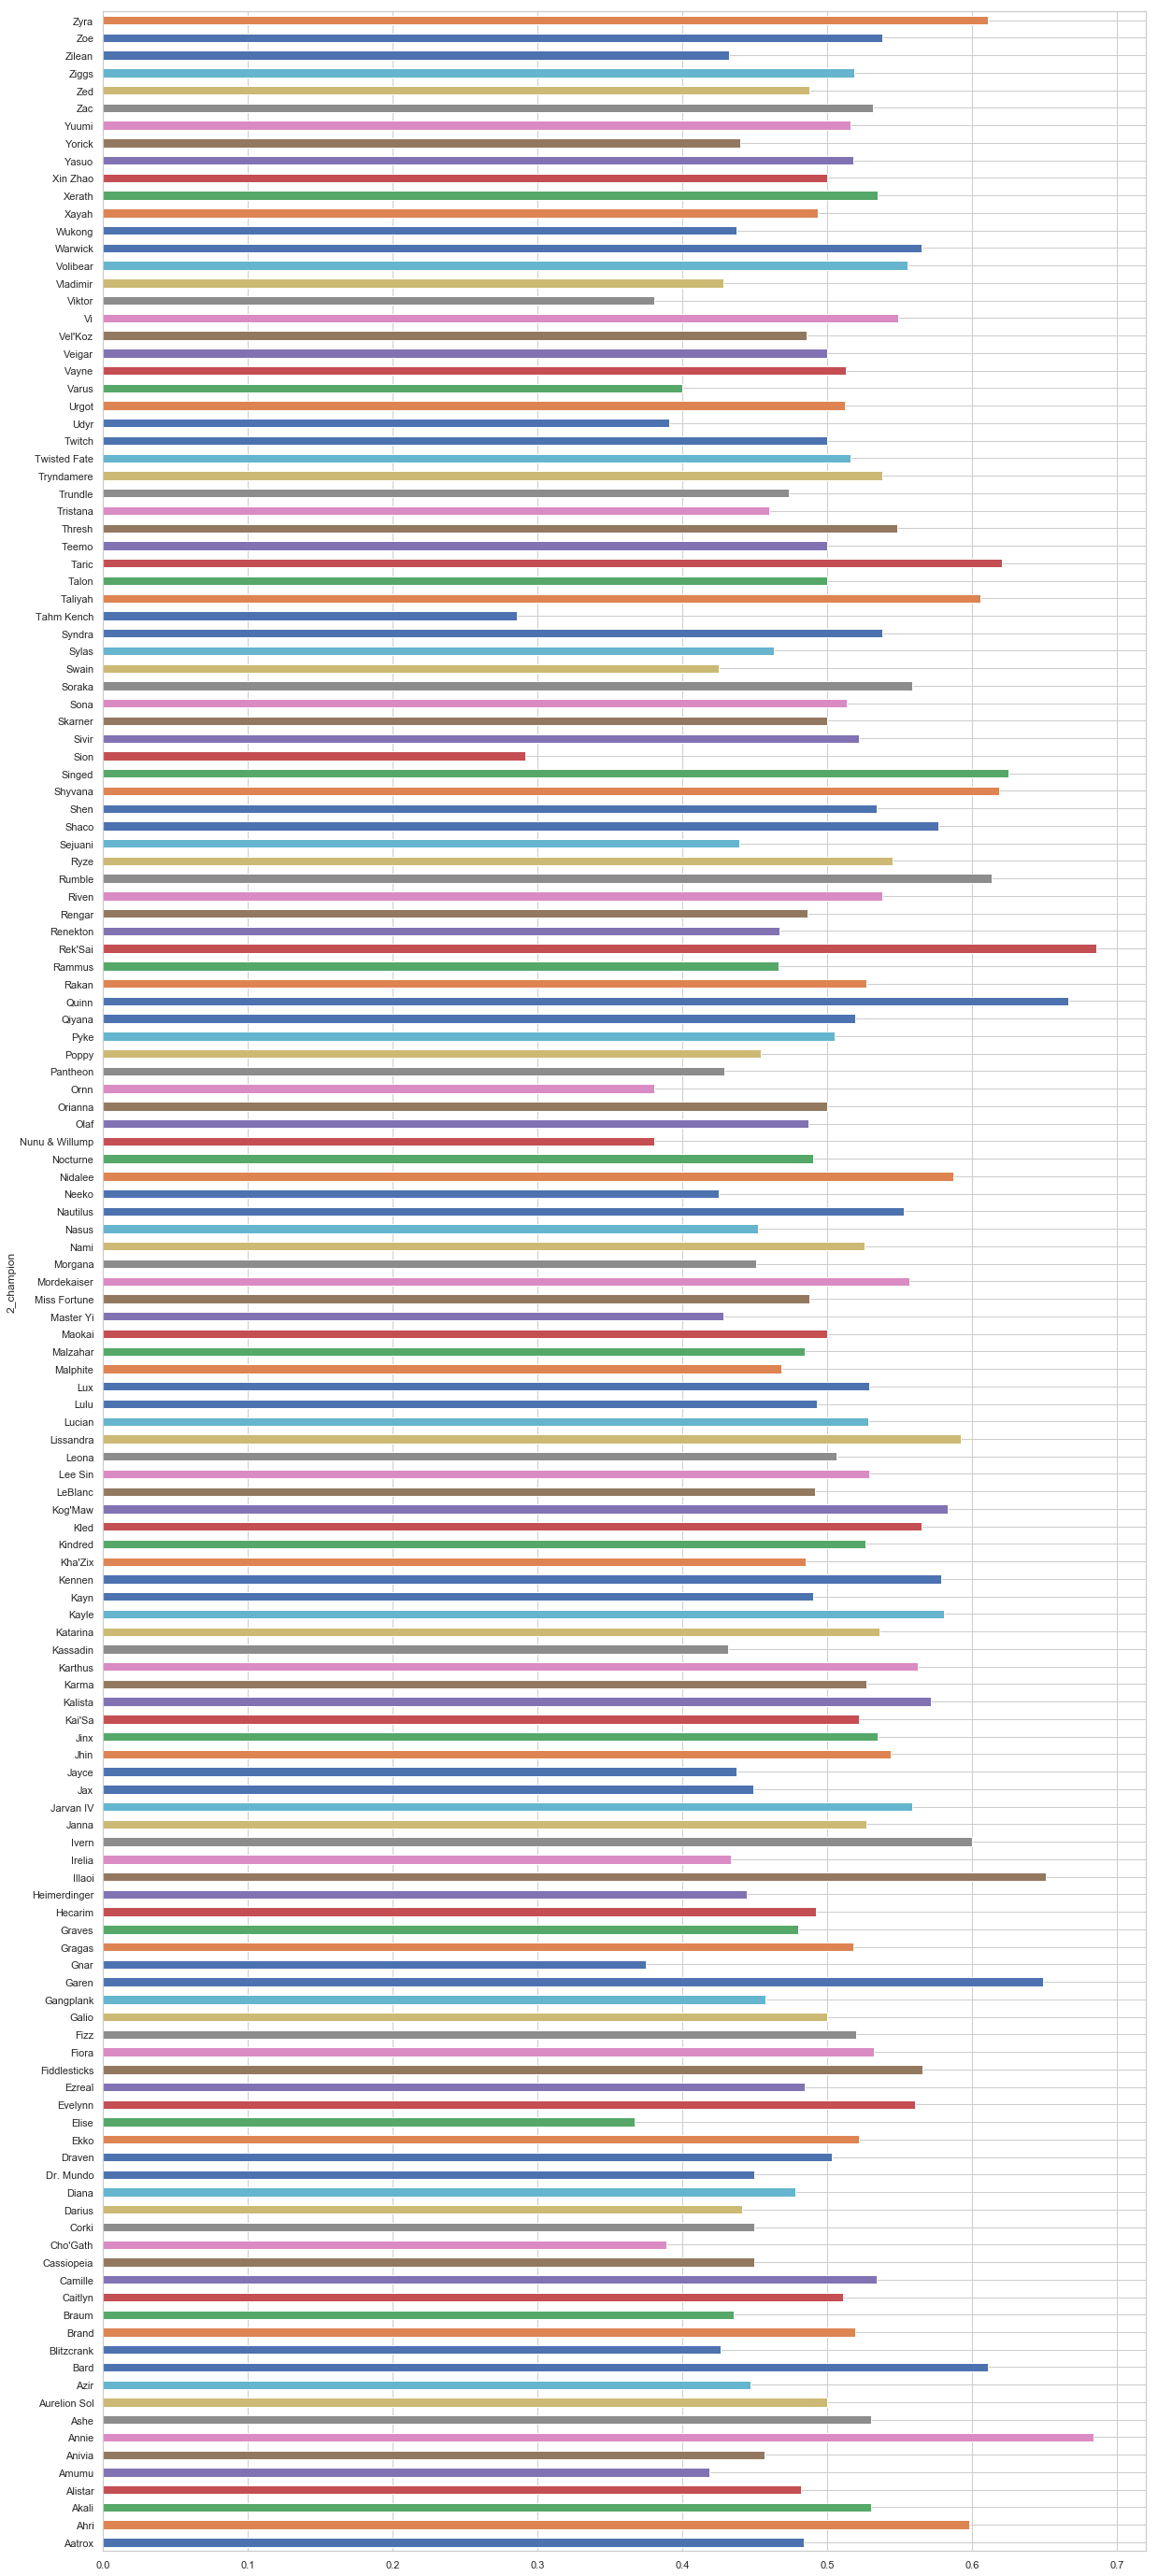

In [261]:
# Exploring '1_champion' only, since I believe it's redundant to explore the rest.
df_grouped_by_champion = df_english_only.groupby('2_champion')
df_grouped_by_champion['won'].mean().plot(kind='barh', figsize=(20, 50));

### This is a bit interesting, because these ratios are different from the ones I got from champion.gg (a 3rd party website for League of Legends statistics).

### It could be because some of these champions have low pick rate, so I didn't get to collect enough games about them.

In [262]:
# Calculating champion's winrate of our data.

grouped_mean_won = df_grouped_by_champion['won'].mean()
grouped_mean_won.sort_values(ascending=False)

2_champion
Rek'Sai           0.685714
Annie             0.684211
Quinn             0.666667
Illaoi            0.651163
Garen             0.649123
Singed            0.625000
Taric             0.620690
Shyvana           0.619048
Rumble            0.613636
Zyra              0.611111
Bard              0.611111
Taliyah           0.606061
Ivern             0.600000
Ahri              0.598214
Lissandra         0.592593
Nidalee           0.586957
Kog'Maw           0.583333
Kayle             0.580645
Kennen            0.578947
Shaco             0.576923
Kalista           0.571429
Fiddlesticks      0.565789
Warwick           0.565217
Kled              0.565217
Karthus           0.562500
Evelynn           0.560606
Jarvan IV         0.559140
Soraka            0.558824
Mordekaiser       0.556818
Volibear          0.555556
                    ...   
Dr. Mundo         0.450000
Jax               0.449275
Azir              0.447368
Heimerdinger      0.444444
Darius            0.441441
Yorick           

In [263]:
# Getting champion's pickrate, that was collected beforehand.

grouped_mean_pickrate = df_grouped_by_champion['2_champion_pickrate'].mean()
grouped_mean_pickrate.sort_values()

2_champion
Galio            0.50
Heimerdinger     0.58
Kalista          0.64
Aurelion Sol     0.65
Maokai           0.68
Kog'Maw          0.72
Tahm Kench       0.77
Lissandra        0.78
Skarner          0.78
Ivern            0.83
Quinn            0.89
Trundle          0.90
Yorick           0.97
Viktor           0.98
Annie            0.99
Ziggs            1.02
Taric            1.02
Sion             1.06
Ornn             1.12
Corki            1.13
Singed           1.16
Azir             1.18
Wukong           1.26
Rumble           1.35
Shyvana          1.36
Anivia           1.37
Cassiopeia       1.44
Jayce            1.46
Urgot            1.47
Gnar             1.55
                ...  
Zed              4.83
Tristana         4.87
Lulu             5.22
Ahri             5.23
Rakan            5.36
Janna            5.66
Nautilus         6.07
Kayn             6.18
Jax              6.47
Yuumi            6.70
Nami             6.71
Xayah            6.73
Morgana          6.79
Jhin             6.81

In [264]:
champion_pick_vs_win = pd.concat([grouped_mean_pickrate, grouped_mean_won], axis=1)

In [265]:
champion_pick_vs_win.head()

,2_champion_pickrate,won
2_champion,,
Aatrox,4.76,0.483871
Ahri,5.23,0.598214
Akali,7.79,0.530612
Alistar,2.59,0.482143
Amumu,2.49,0.418605


### My hunch was correct, we can see that the higher the pick rate is the more stable the winrate gets.

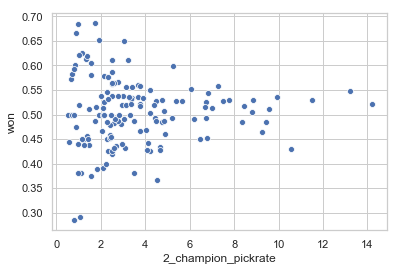

In [266]:
sns.scatterplot(x="2_champion_pickrate", y="won", data=champion_pick_vs_win);

### In the end I think I'm going with four features for fitting my models, kda, winrate, cm_points, and champion_winrate.

### I didn't go with the runes, or champion columns, because of the sheer amount of unique values it has, and I would like to think that creating that many dummy variables would have negative outcomes (since I would need to create dummy variables for each player).

In [273]:
df['1_champion'].nunique()

575

In [270]:
df['1_runes'].nunique()

116

### I was gonna attempt to sort the players columns by role, but that proved to be harder than I thought. Because I can't get a player's role when spectating a live match, I tried brute forcing the players roles but that didn't give many good results because of the way the current META (Most Effective Tactic Available) is, champions get picked to many different roles each.

### This could be a problem in of itself that I could probably attempt to solve in the near future.

# III - Machine Learning

## Setup:

In [12]:
# Generating features list.

features = list()
main_features = ['kda', 'winrate', 'cm_points', 'champion_winrate']

for i in range(1, 11):
    for feature in main_features:
        features.append(f'{i}_{feature}')
        
features

['1_kda',
 '1_winrate',
 '1_cm_points',
 '1_champion_winrate',
 '2_kda',
 '2_winrate',
 '2_cm_points',
 '2_champion_winrate',
 '3_kda',
 '3_winrate',
 '3_cm_points',
 '3_champion_winrate',
 '4_kda',
 '4_winrate',
 '4_cm_points',
 '4_champion_winrate',
 '5_kda',
 '5_winrate',
 '5_cm_points',
 '5_champion_winrate',
 '6_kda',
 '6_winrate',
 '6_cm_points',
 '6_champion_winrate',
 '7_kda',
 '7_winrate',
 '7_cm_points',
 '7_champion_winrate',
 '8_kda',
 '8_winrate',
 '8_cm_points',
 '8_champion_winrate',
 '9_kda',
 '9_winrate',
 '9_cm_points',
 '9_champion_winrate',
 '10_kda',
 '10_winrate',
 '10_cm_points',
 '10_champion_winrate']

In [7]:
def get_train_test_split(df, features, target):
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [8]:
def train_model(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    return model, y_predict

In [277]:
X_train, X_test, y_train, y_test = get_train_test_split(df, features, 'won')

In [73]:
# Source: https://gist.github.com/conditg/b168929e5ddfdff829ee422d9b2593d1#file-logrfunction-py

def eval_binary_classifier(model, x, y, labels=['Positives','Negatives']):
    '''
    Visualize the performance of  a Logistic Regression Binary Classifier.

    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts

    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or
        LogisticRegressionCV

    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features

    y : array-like, shape (n_samples,)
        Target vector relative to x.

    labels: list, optional
        list of text labels for the two classes, with the positive label first

    Displays
    ----------
    3 Subplots

    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]

    #FIGURE
    plt.figure(figsize=[15,4])

    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
                annot_kws={"size": 14}, fmt='g')
#     ax.set_facecolor('#f3f3f3') was using this when I was taking a picture for my presentation.
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
        t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)

    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")

    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1


## Logistic Regression:

In [309]:
lr, y_predict = train_model(LogisticRegression(), X_train, y_train, X_test)

In [310]:
accuracy_score(y_test, y_predict)

0.5475202097443741

### By looking at the distributions of predictions we can quickly see that the model isn't really sure of it's predictions. 

### This is supported by looking at the ROC curve, which tells us that this model is mostly picking randomly.

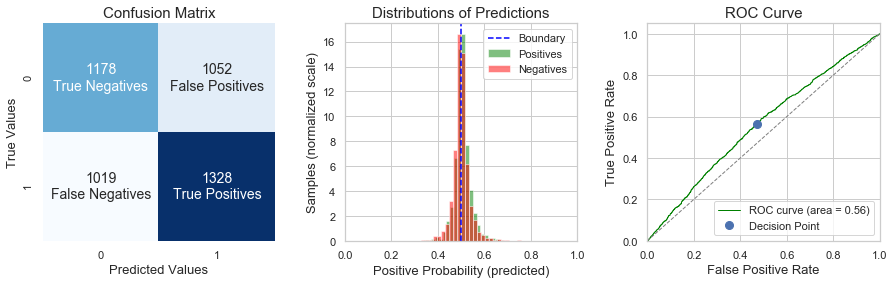

Precision: 0.56 | Recall: 0.57 | F1 Score: 0.56 | 


0.5618785699174952

In [298]:
eval_binary_classifier(lr, X_test, y_test)

In [300]:
print(classification_report(y_test, y_predict, target_names=['Won', 'Lost']))

              precision    recall  f1-score   support

         Won       0.54      0.53      0.53      2230
        Lost       0.56      0.57      0.56      2347

   micro avg       0.55      0.55      0.55      4577
   macro avg       0.55      0.55      0.55      4577
weighted avg       0.55      0.55      0.55      4577



### I had a feeling Logistic Regression wouldn't yield any good results, but I had to check it out. I don't think this model could work for a problem like this just because of the nature of its decision boundaries.

## Random Forests:

In [311]:
rfc, y_predict = train_model(RandomForestClassifier(n_estimators=500), X_train, y_train, X_test)

In [312]:
accuracy_score(y_test, y_predict)

0.5896875682761634

### The distribution this time tells that the model is pretty sure about some of the predictions, but the majority is still done at random.

### The ROC curve is not that much better also.

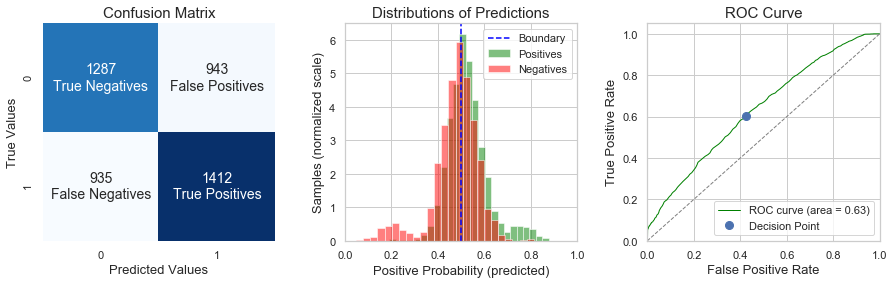

Precision: 0.6 | Recall: 0.6 | F1 Score: 0.6 | 


0.6005954912803062

In [313]:
eval_binary_classifier(rfc, X_test, y_test)

In [314]:
print(classification_report(y_test, y_predict, target_names=['Won', 'Lost']))

              precision    recall  f1-score   support

         Won       0.58      0.58      0.58      2230
        Lost       0.60      0.60      0.60      2347

   micro avg       0.59      0.59      0.59      4577
   macro avg       0.59      0.59      0.59      4577
weighted avg       0.59      0.59      0.59      4577



### Looking at the feature_importances_ we can see that the model thinks that cm_points is the most important feature in our data.

### This leads me to believe that if I fit the model with the outliers reduced it could lead to better results.

In [99]:
feature_imp = pd.Series(rfc.feature_importances_, index=features).sort_values(ascending=False)
feature_imp[:10]

3_cm_points           0.043537
2_cm_points           0.038250
5_cm_points           0.036963
4_cm_points           0.036870
10_cm_points          0.035597
8_cm_points           0.035322
7_cm_points           0.035181
1_cm_points           0.033573
6_cm_points           0.032713
5_champion_winrate    0.031716
dtype: float64

## Gradient Boosting:

In [316]:
gbc, y_predict = train_model(GradientBoostingClassifier(), X_train, y_train, X_test)

In [317]:
accuracy_score(y_test, y_predict)

0.5840069914791348

### This is quite similar to Random Forests, but I think that if tuned correctly this should give better results.

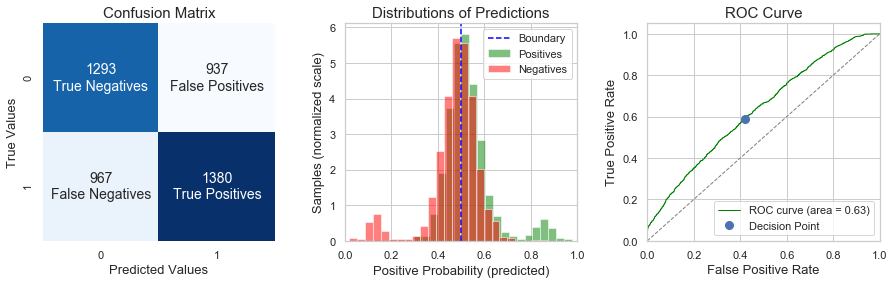

Precision: 0.6 | Recall: 0.59 | F1 Score: 0.59 | 


0.5917667238421955

In [319]:
eval_binary_classifier(gbc, X_test, y_test)

In [320]:
print(classification_report(y_test, y_predict, target_names=['Won', 'Lost']))

              precision    recall  f1-score   support

         Won       0.57      0.58      0.58      2230
        Lost       0.60      0.59      0.59      2347

   micro avg       0.58      0.58      0.58      4577
   macro avg       0.58      0.58      0.58      4577
weighted avg       0.58      0.58      0.58      4577



### Same as above with cm_points columns.

In [318]:
feature_imp = pd.Series(gbc.feature_importances_, index=features).sort_values(ascending=False)
feature_imp[:10]

10_cm_points    0.088764
8_cm_points     0.075240
4_cm_points     0.073966
2_cm_points     0.072555
1_cm_points     0.070144
9_cm_points     0.068523
5_cm_points     0.068140
3_cm_points     0.065805
7_cm_points     0.065078
6_cm_points     0.053835
dtype: float64

### I was feeling like the number of games I have isn't enough, but this leads me to believe that it's fine. I think that more games could lead to better results, but it takes a lot of time to collect these matches since they limit my API usage per minute.

In [68]:
# Testing out different sample sizes.

sample_size = [16000, 14000, 12000, 10000, 8000, 6000, 4000, 2000, 1000]

for sample in reversed(sample_size):
    df_temp = df.iloc[:sample]
    
    X = df_temp[features]
    y = df_temp['won']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    rfc = RandomForestClassifier(n_estimators=250)
    rfc.fit(X_train, y_train)
    
    gbc = GradientBoostingClassifier()
    gbc.fit(X_train, y_train)

    print(sample, round(np.mean(y_test == lr.predict(X_test)), 2), round(np.mean(y_test == rfc.predict(X_test)), 2), round(np.mean(y_test == gbc.predict(X_test)), 2))

1000 0.55 0.5 0.52
2000 0.51 0.58 0.57
4000 0.55 0.57 0.58
6000 0.54 0.58 0.57
8000 0.53 0.59 0.58
10000 0.53 0.58 0.58
12000 0.53 0.55 0.56
14000 0.54 0.57 0.55
16000 0.54 0.59 0.58


## Exploring Random Forests, and Gradient Boosting:

In [13]:
# Getting new test, and train data.
X_train, X_test, y_train, y_test = get_train_test_split(df_no_outliers, features, 'won')

### This is already giving better results, even without that much parameters tuning.

In [332]:
rfc, y_predict = train_model(RandomForestClassifier(n_estimators=1000), X_train, y_train, X_test)

In [333]:
accuracy_score(y_test, y_predict)

0.5982819605861546

In [334]:
print(classification_report(y_test, y_predict, target_names=['Won', 'Lost']))

              precision    recall  f1-score   support

         Won       0.60      0.57      0.59       990
        Lost       0.59      0.62      0.61       989

   micro avg       0.60      0.60      0.60      1979
   macro avg       0.60      0.60      0.60      1979
weighted avg       0.60      0.60      0.60      1979



In [335]:
gbc, y_predict = train_model(GradientBoostingClassifier(), X_train, y_train, X_test)

In [336]:
accuracy_score(y_test, y_predict)

0.6104092976250631

In [337]:
print(classification_report(y_test, y_predict, target_names=['Won', 'Lost']))

              precision    recall  f1-score   support

         Won       0.62      0.58      0.60       990
        Lost       0.60      0.65      0.62       989

   micro avg       0.61      0.61      0.61      1979
   macro avg       0.61      0.61      0.61      1979
weighted avg       0.61      0.61      0.61      1979



### Looking at the distributions of predictions, gradient boosting is looking more confident than random forests

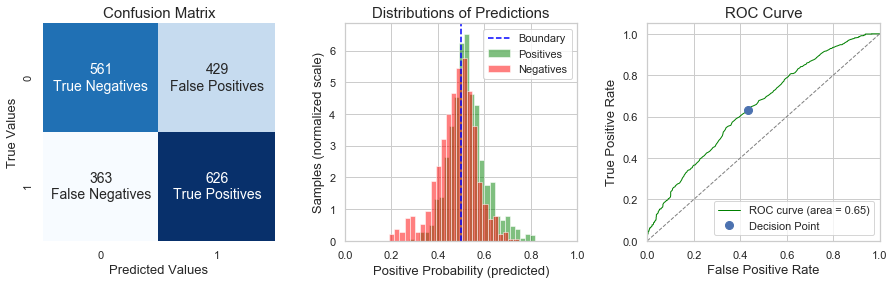

Precision: 0.59 | Recall: 0.63 | F1 Score: 0.61 | 


0.6125244618395304

In [330]:
eval_binary_classifier(rfc, X_test, y_test)

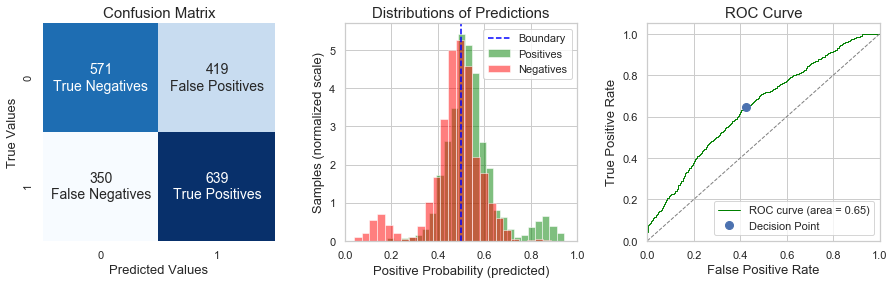

Precision: 0.6 | Recall: 0.65 | F1 Score: 0.62 | 


0.6243282852955545

In [328]:
eval_binary_classifier(gbc, X_test, y_test)

### Now let's try tuning some parameters.

### Starting with n_estimators:

### 100 n_estimators seems to hit the sweet spot for Gradient Boosting, which is weird because Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

### Random Forests, seems to get better the higher the n_estimators gets.

In [347]:
# Added the default n_estimators for easier comparing.
n_estimators = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]

for estimator in n_estimators:
    rfc, y_predict = train_model(RandomForestClassifier(n_estimators=estimator, n_jobs=-1), X_train, y_train, X_test)
    rfc_score = f'Random Forests\t\t{estimator}\t{accuracy_score(y_test, y_predict)}%'
    
    gbc, y_predict = train_model(GradientBoostingClassifier(n_estimators=estimator), X_train, y_train, X_test)
    gbc_score = f'Gradient Boosting\t{estimator}\t{accuracy_score(y_test, y_predict)}%'
    
    print(f'{rfc_score}\t\t{gbc_score}')

Random Forests		10	0.562910560889338%		Gradient Boosting	10	0.5462354724608388%
Random Forests		100	0.5811015664477008%		Gradient Boosting	100	0.6109146033350177%
Random Forests		200	0.596766043456291%		Gradient Boosting	200	0.6008084891359272%
Random Forests		300	0.5962607377463366%		Gradient Boosting	300	0.595755432036382%
Random Forests		400	0.5881758463870642%		Gradient Boosting	400	0.595755432036382%
Random Forests		500	0.5942395149065185%		Gradient Boosting	500	0.5912076806467913%
Random Forests		600	0.6068721576553815%		Gradient Boosting	600	0.5816068721576554%
Random Forests		700	0.6058615462354725%		Gradient Boosting	700	0.5805962607377463%
Random Forests		800	0.6058615462354725%		Gradient Boosting	800	0.5805962607377463%
Random Forests		900	0.607377463365336%		Gradient Boosting	900	0.5689742294087923%
Random Forests		1000	0.605356240525518%		Gradient Boosting	1000	0.5624052551793836%
Random Forests		1100	0.605356240525518%		Gradient Boosting	1100	0.5740272865083376%
Random Fo

### max_depth:

### Missing with max_depth doesn't seem to give better results for some reason. I probably need to try larger depth sizes.

In [350]:
for depth in range(1, 33):
    rfc, y_predict = train_model(RandomForestClassifier(n_estimators=1200, max_depth=depth, n_jobs=-1), 
                                 X_train, y_train, X_test)
    rfc_score = f'Random Forests\t\t{depth}\t{accuracy_score(y_test, y_predict)}%'
    
    gbc, y_predict = train_model(GradientBoostingClassifier(n_estimators=100, max_depth=depth), X_train, y_train, X_test)
    gbc_score = f'Gradient Boosting\t{depth}\t{accuracy_score(y_test, y_predict)}%'
    
    print(f'{rfc_score}\t\t{gbc_score}')

Random Forests		1.0	0.5533097524002021%		Gradient Boosting	1.0	0.5871652349671551%
Random Forests		2.0	0.5679636179888833%		Gradient Boosting	2.0	0.6003031834259727%
Random Forests		3.0	0.5917129863567459%		Gradient Boosting	3.0	0.6114199090449722%
Random Forests		4.0	0.5896917635169278%		Gradient Boosting	4.0	0.6043456291056089%
Random Forests		5.0	0.5997978777160182%		Gradient Boosting	5.0	0.5932289034866094%
Random Forests		6.0	0.5997978777160182%		Gradient Boosting	6.0	0.5901970692268823%
Random Forests		7.0	0.6058615462354725%		Gradient Boosting	7.0	0.5770591207680646%
Random Forests		8.0	0.6119252147549268%		Gradient Boosting	8.0	0.5674583122789287%
Random Forests		9.0	0.6063668519454269%		Gradient Boosting	9.0	0.5816068721576554%
Random Forests		10.0	0.6099039919151087%		Gradient Boosting	10.0	0.5720060636685195%
Random Forests		11.0	0.608388074785245%		Gradient Boosting	11.0	0.5821121778676099%
Random Forests		12.0	0.6093986862051541%		Gradient Boosting	12.0	0.5704901465386559%

### Gradient Boosting learning_rate:

### It looks like the default values for Gradient Boosting works best, since missing with the learning rate, or the max_depth parameters could result in underfitting.

In [386]:
learning_rates = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in learning_rates:
    gbc, y_predict = train_model(GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate), X_train, y_train, X_test)
    print(f'Gradient Boosting\t{learning_rate}\t{accuracy_score(y_test, y_predict)}%')

Gradient Boosting	0.05	0.6058615462354725%
Gradient Boosting	0.075	0.6038403233956544%
Gradient Boosting	0.1	0.6109146033350177%
Gradient Boosting	0.25	0.5917129863567459%
Gradient Boosting	0.5	0.5679636179888833%
Gradient Boosting	0.75	0.5644264780192016%
Gradient Boosting	1	0.5624052551793836%


## GridSearchCV:

### I didn't get good results with this, and I think it's because I didn't add more parameters because it was taking so long to process.

In [399]:
# I removed max_depth since it was taking so long.

parameters = {
#     'max_depth': np.linspace(1, 32, 32),
    'n_estimators': [800, 1000, 1200],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_features': 'log2', 'n_estimators': 800}
0.5690933602965959


In [401]:
rfc, y_predict = train_model(RandomForestClassifier(n_estimators=800, max_features='log2'), X_train, y_train, X_test)
accuracy_score(y_test, y_predict)

0.6038403233956544

In [400]:
# I removed max_depth since it was taking so long.

parameters = {
#     'max_depth': np.linspace(1, 32, 32),
    'learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
    'n_estimators': [800, 1000, 1200],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(GradientBoostingClassifier(), parameters, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'learning_rate': 0.05, 'max_features': 'log2', 'n_estimators': 800}
0.5631951466127402


In [479]:
gbc, y_predict = train_model(GradientBoostingClassifier(n_estimators=800, max_features='log2', learning_rate=0.05), X_train, y_train, X_test)
accuracy_score(y_test, y_predict)

0.5972713491662456

## Scalers:

### I thought of using robust scalers since I have a lot of outliers, and I was attempting to lower their effect on the model.

### However, I didn't good results and I think that I should play with this more in the future.

In [442]:
scaler = RobustScaler(quantile_range=(0.1,0.9))

X_train_scaled = X_train.copy()
X_train_scaled[points_columns] = scaler.fit_transform(X_train_scaled[points_columns])

X_test_scaled = X_test.copy()
X_test_scaled[points_columns] = scaler.fit_transform(X_test_scaled[points_columns])

In [446]:
rfc, y_predict = train_model(RandomForestClassifier(n_estimators=800, max_features='log2'), X_train_scaled, y_train, X_test_scaled)
accuracy_score(y_test, y_predict)

0.5598787266296109

In [445]:
gbc, y_predict = train_model(GradientBoostingClassifier(n_estimators=100, max_features='log2', learning_rate=0.05), X_train_scaled, y_train, X_test_scaled)
accuracy_score(y_test, y_predict)

0.562910560889338

## Extra Stuff:

### These are live matches that I pulled today (8/9/2019), and wanted to test the best scoring models on.

In [52]:
rfc, y_predict = train_model(RandomForestClassifier(n_estimators=1200, max_depth=20, max_features='log2'), X_train, y_train, X_test)

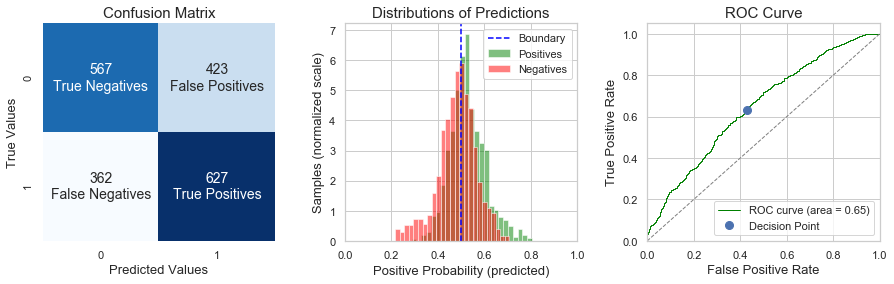

Precision: 0.6 | Recall: 0.63 | F1 Score: 0.62 | 


0.6150073565473272

In [53]:
eval_binary_classifier(rfc, X_test, y_test)

In [54]:
gbc, y_predict = train_model(GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_features='log2'), X_train, y_train, X_test)

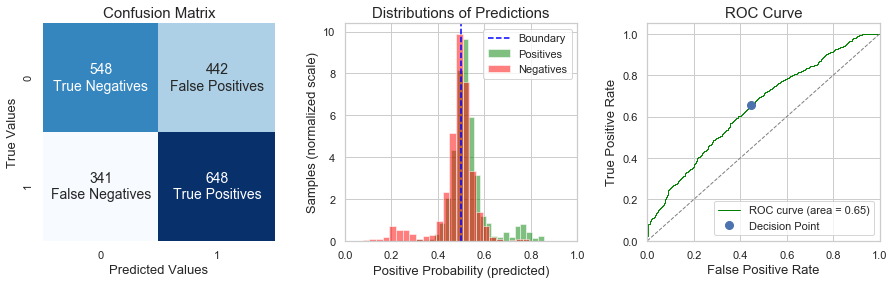

Precision: 0.59 | Recall: 0.66 | F1 Score: 0.62 | 


0.6233766233766235

In [55]:
eval_binary_classifier(gbc, X_test, y_test)

### I'll be using the Gradient Boosting model, because I believe that it'll out performs the Random Forests mode.

In [60]:
# Import live games... and try to predict them.
spectator_df = pd.read_csv('spectator_data.csv')

In [61]:
spectator_df.head()

,match_id,1_kda,1_winrate,1_cm_points,1_champion_winrate,2_kda,2_winrate,2_cm_points,2_champion_winrate,3_kda,...,8_cm_points,8_champion_winrate,9_kda,9_winrate,9_cm_points,9_champion_winrate,10_kda,10_winrate,10_cm_points,10_champion_winrate
0,4183920090,2.04,0.50,4132.0,46.88,3.65,0.39,19276.0,49.47,5.75,...,120319.0,48.88,2.73,0.44,114859.0,44.86,3.64,0.67,2292.0,50.97
1,4183991488,4.25,0.78,51433.0,50.73,5.51,0.58,83668.0,46.44,5.01,...,0.0,50.39,3.37,0.52,16963.0,49.76,8.34,1.00,98293.0,51.49
2,4183951281,3.99,0.55,130569.0,47.51,4.30,0.58,232219.0,49.04,2.57,...,2278.0,49.76,5.90,0.83,18160.0,47.49,0.00,0.00,175933.0,48.13
3,4183951838,4.51,0.40,909598.0,50.61,5.46,0.68,748213.0,48.18,1.98,...,159947.0,51.59,4.32,0.62,27299.0,50.15,6.27,0.62,172267.0,51.11
4,4183966652,0.00,0.00,16882.0,48.12,6.41,0.75,19158.0,50.65,5.46,...,3423.0,44.85,3.19,0.50,648222.0,50.61,4.53,0.51,1274328.0,51.26


In [62]:
gbc_predictions = gbc.predict(spectator_df[features])
rfc_predictions = rfc.predict(spectator_df[features])

In [65]:
results_df = pd.read_csv('spectator_results.csv')

In [66]:
matches_ids = spectator_df.match_id.values
matches_results = results_df.won.values

### These results are really close to testing ones, but I think the RF model is working randomly sometimes. However, I think that the GB model is pretty sure about some of it's predictions.

In [72]:
for (m_id, gbc_p, rfc_p, actual) in zip(matches_ids, gbc_predictions, rfc_predictions, matches_results):
    gbc_team = 'Blue' if gbc_p else 'Red'
    rfc_team = 'Blue' if rfc_p else 'Red'
    actual_team = 'Blue' if actual else 'Red'
    print(f'Match: {m_id}\tGB Prediction: {gbc_team} Team wins\t\tRF Prediction: {rfc_team}\tActual: {actual_team}')

print('\n')
print(f"Gradient Boosting's Accuracy: {accuracy_score(matches_results, gbc_predictions)}")
print(f"Random Forests's Accuracy: {accuracy_score(matches_results, rfc_predictions)}")

Match: 4183920090	GB Prediction: Blue Team wins		RF Prediction: Red	Actual: Blue
Match: 4183991488	GB Prediction: Blue Team wins		RF Prediction: Blue	Actual: Blue
Match: 4183951281	GB Prediction: Blue Team wins		RF Prediction: Blue	Actual: Red
Match: 4183951838	GB Prediction: Blue Team wins		RF Prediction: Blue	Actual: Blue
Match: 4183966652	GB Prediction: Blue Team wins		RF Prediction: Blue	Actual: Red
Match: 4183977379	GB Prediction: Red Team wins		RF Prediction: Red	Actual: Red
Match: 4184010573	GB Prediction: Blue Team wins		RF Prediction: Blue	Actual: Blue
Match: 4184041991	GB Prediction: Red Team wins		RF Prediction: Blue	Actual: Blue
Match: 4184032607	GB Prediction: Red Team wins		RF Prediction: Red	Actual: Red
Match: 4184033593	GB Prediction: Blue Team wins		RF Prediction: Blue	Actual: Red


Gradient Boosting's Accuracy: 0.6
Random Forests's Accuracy: 0.6


## Conclusion:

### Firstly, I would like to thank my amazing instructors James Larkin, and Norah Alhomaimidi for always being there when I needed help, and I would like to thank MiSK Academy, and General Assembly for this great opportunity. Second, this project has been a wonderful experience overall, I gained so many new skills, plus I learned so much about data  manipulation, machine learning, and using an API to get my data live, and pre-engineering it for my needs.

### Third, the results that I got on this project are really interesting, and further supports my initial hypothesis that player's skill far outways the champion's strength. Lastly, I don't plan on stopping here, I'll be further experimenting with this game, since I truly believe that this field is in need of more advanced ways to improve the players in unforseen ways.